In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)
initial objective function: 5448.23 (53 data)

running optimization...
objective function: 50.21 (53 data)
# elapsed time (least square): 1.4 sec


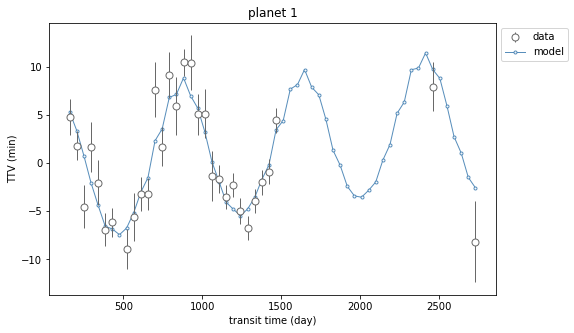

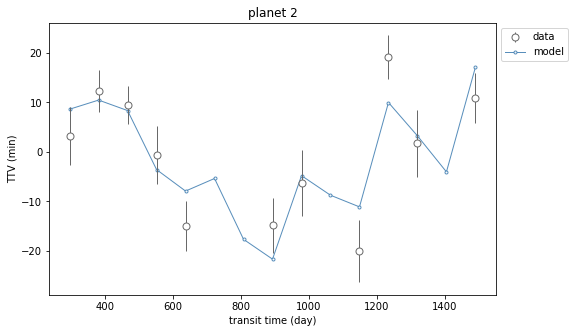

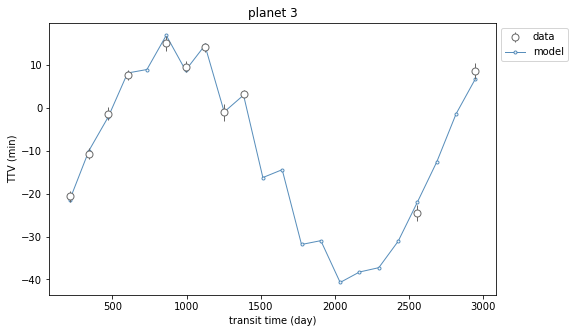

In [2]:
d = pd.read_csv("/Users/k_masuda/Dropbox/repos/jnkepler/examples/kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

#%%
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt)
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

#%%
params_best = jttv.optim(mmax=1e-4, emax=0.1)

In [3]:
elements, masses = params_to_elements(params_best, jttv.nplanet)

In [4]:
from jnkepler.jaxttv.utils import *
from jnkepler.jaxttv.symplectic import *
from jnkepler.jaxttv.findtransit import *
from flux import *

In [6]:
self = jttv
xjac0, vjac0 = initialize_jacobi_xv(elements, masses, self.t_start) # initial Jacobi position/velocity
times, xvjac = integrate_xv(xjac0, vjac0, masses, self.times, nitr=self.nitr_kepler) # integration
orbit_idx = self.pidx.astype(int) - 1 # idx for orbit, starting from 0
tcobs1d = self.tcobs_flatten
tc, (xcm, vcm, _) = find_transit_params_all(orbit_idx, tcobs1d, times, xvjac, masses)

In [7]:
times_lc = np.sort(np.array([np.array(self.tcobs_flatten)+dt for dt in np.linspace(-1, 1, 251)]).ravel())
times_lc_tidx = findidx_map(self.tcobs_flatten, times_lc)
times_lc_pidx = self.pidx[times_lc_tidx].astype(int) - 1

In [8]:
prad = jnp.array([0.08, 0.09, 0.1])
rstar = 1.
u1, u2 = 0.5, 0.2

In [21]:
%%timeit
nbodyflux = compute_nbody_flux(rstar, prad, u1, u2, times_lc, times_lc_tidx, times_lc_pidx, 
                               tc, xcm, vcm, orbit_idx+1)

373 µs ± 5.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


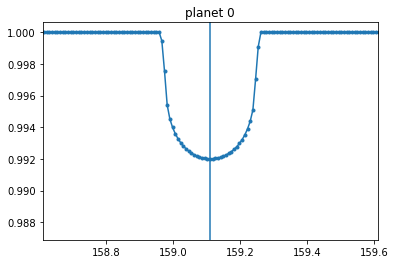

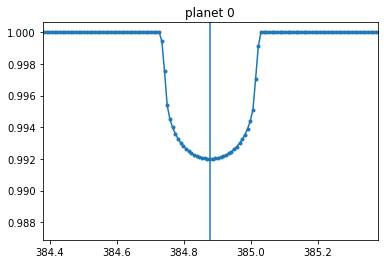

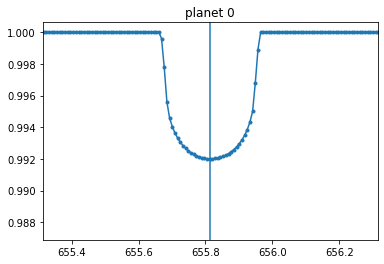

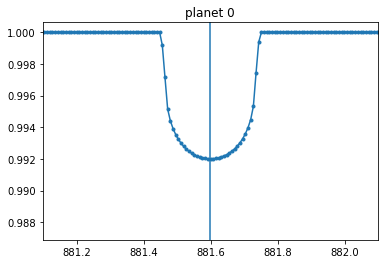

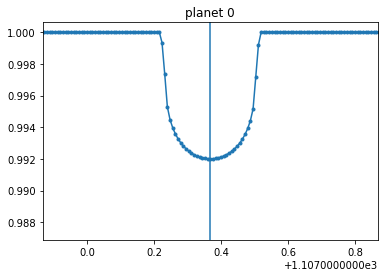

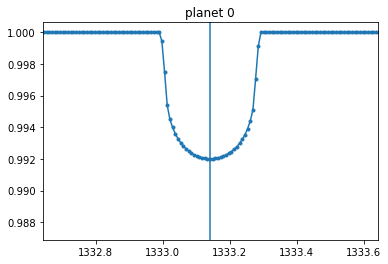

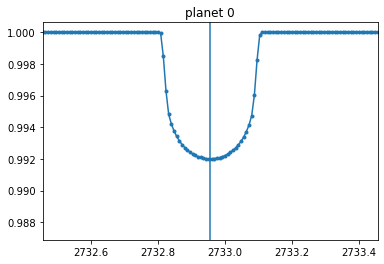

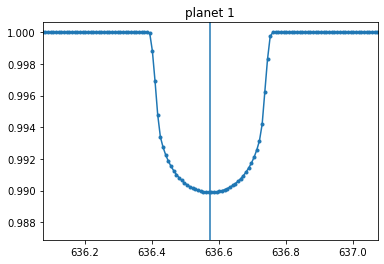

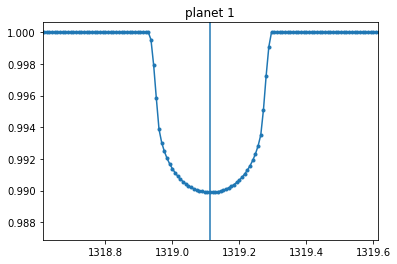

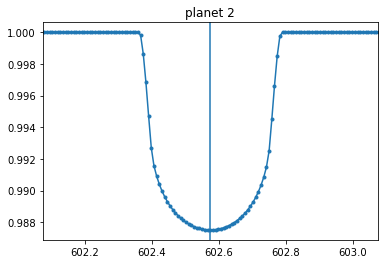

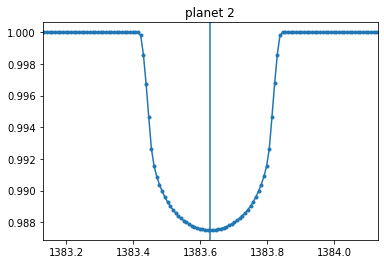

In [32]:
for _tc, _p in zip(tc[::5], orbit_idx[::5]):
    plt.figure()
    plt.xlim(_tc-0.5, _tc+0.5)
    plt.axvline(x=_tc)
    plt.title("planet %d"%_p)
    plt.plot(times_lc, nbodyflux, '.-')